In [17]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

In [19]:
from rnn_utils import ALL_LETTERS, N_LETTERS
from rnn_utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [21]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

In [25]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [27]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

In [29]:
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [31]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

In [35]:
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [39]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Polish


In [41]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [43]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [45]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.6295 Vo / Italian WRONG (Vietnamese)
10000 10.0 1.2760 Yamahata / Japanese CORRECT
15000 15.0 2.1599 Sarkozy / English WRONG (French)
20000 20.0 0.1720 Arvanitoyannis / Greek CORRECT
25000 25.0 1.1420 Thai / Chinese WRONG (Vietnamese)
30000 30.0 1.4208 Absattaroff / Russian CORRECT
35000 35.0 0.6763 Amalberti / Italian CORRECT
40000 40.0 1.3508 Hung / Chinese WRONG (Korean)
45000 45.0 1.7789 Loh / Korean WRONG (Chinese)
50000 50.0 3.4752 Kohl / Korean WRONG (German)
55000 55.00000000000001 1.3348 Cheung / Vietnamese WRONG (Chinese)
60000 60.0 0.4299 Ly / Vietnamese CORRECT
65000 65.0 2.3854 Okazaki / Polish WRONG (Japanese)
70000 70.0 1.3115 Mentis / Greek CORRECT
75000 75.0 0.9541 Brady / Irish CORRECT
80000 80.0 0.6290 Foerstner / German CORRECT
85000 85.0 0.0121 Manoukarakis / Greek CORRECT
90000 90.0 0.8690 Kraemer / German CORRECT
95000 95.0 0.3449 Cunningham / Scottish CORRECT
100000 100.0 1.6552 De la fontaine / English WRONG (French)


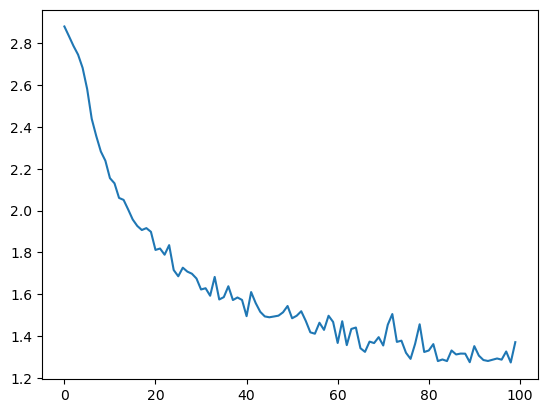

In [47]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [53]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [55]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)

Input: Dorywalski



> Dorywalski
Polish


Input: Shmidt



> Shmidt
Japanese


Input: quit
